> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/SearchDownload_SWOTviaCMR.ipynb).

Altered version by Ben Kraas
Original version by Cassandra Nickles, PO.DAAC

# Search and Download SWOT Data via `earthaccess`

## Summary
This notebook will find and download pre-validated SWOT hydrology data (v2.0) programmatically via earthaccess python library. For more information about earthaccess visit: https://nsidc.github.io/earthaccess/

## Requirements
### 1. Compute environment 
This tutorial can be run in the following environments:
- **Local compute environment** e.g. laptop, server: this tutorial can be run on your local machine

### 2. Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

In [2]:
# Standard library imports
import os
import glob
from pathlib import Path
import zipfile

# Third-party library imports
import geopandas as gpd
import pandas as pd
import contextily as ctx
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4

# Earthaccess library import
import earthaccess

# Matplotlib inline magic command
%matplotlib inline

In [3]:
# setup directories and files
data_dir = Path('data')
sampling_points_shapefile = Path("res") / "Reservoirs.shp"
lake_vector_shapefile_dir = data_dir / 'lake_vector_shapefiles'
water_mask_pixel_cloud_dir = data_dir / 'water_mask_pixel_cloud'

# set parameters
temporal_range = ('2019-01-01', '2019-12-31') # tuple of start and end date ((YYYY-MM-DD HH:MM:SS), ...)

In this notebook, we will be calling the authentication in the below cell.

In [10]:
auth = earthaccess.login()

# REVIEW: At some point, a token-based authentication is planned to be implemented by the earthaccess team:
# See: https://github.com/nsidc/earthaccess/issues/484

### Search for SWOT data links
We want to find the SWOT files for a particular pass over North America. 

Each dataset has it's own unique shortname, which can be used to search earthaccess. Shortnames can be found on dataset landing pages or [Earthdata Search](https://search.earthdata.nasa.gov/search) Collections.

#### SWOT Level 2 KaRIn High Rate Version 2.0 Datasets:

- **Water Mask Pixel Cloud NetCDF** - SWOT_L2_HR_PIXC_2.0
- **Water Mask Pixel Cloud Vector Attribute NetCDF** - SWOT_L2_HR_PIXCVec_2.0
- **River Vector Shapefile** - SWOT_L2_HR_RiverSP_2.0
- **Lake Vector Shapefile** - SWOT_L2_HR_LakeSP_2.0
- **Raster NetCDF** - SWOT_L2_HR_Raster_2.0

Let's start our search for River Vector Shapefiles with a particular pass, pass 013. SWOT files come in "reach" and "node" versions in the same collection, here we want the 10km reaches rather than the nodes. We will also only get files for North America, or 'NA' and call out a specific pass number that we want.

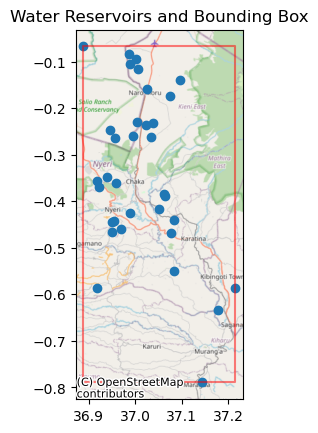

In [5]:
# get the bounding box of the reservoirs
water_reservoirs = gpd.read_file(sampling_points_shapefile) # open the shapefile data/Reservoirs.shp
water_reservoirs = water_reservoirs.to_crs(epsg=4326) 		# Set the CRS to WGS84 (lat/lon)
bbox = water_reservoirs.geometry.union_all().bounds 		# get the outer bounds of all reservoirs combined
bbox_gdf = gpd.GeoDataFrame(geometry=[water_reservoirs.geometry.union_all().envelope]) 	# create a GeoDataFrame with the bounding box

# plot the bounding box and the reservoirs
ax = water_reservoirs.plot()
bbox_gdf.boundary.plot(ax=ax, color='red', alpha=0.5)
ctx.add_basemap(ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:4326')
ax.set_title('Water Reservoirs and Bounding Box')
ax.set_aspect('equal')
ax.figure.show()

In [6]:
# search for SWOT data in the bounding box region and download it to the datasets directory
# 1. search for the vector data (lake shapefiles)
# 2. search for the pixel cloud data.

# # ---------
# # This code may not be necessary as the vector data is quite useless... 
#
# # if the directory exists and there are files in it, skip the download
# if lake_vector_shapefile_dir.exists() and len(list(lake_vector_shapefile_dir.glob('*.zip'))) > 0:
#     print(f"Found {len(list(lake_vector_shapefile_dir.glob('*.zip')))} existing vector files in {lake_vector_shapefile_dir}. Skipping download.")
# else:
#     results = earthaccess.search_data(short_name = 'SWOT_L2_HR_LakeSP_2.0', 
#                                     temporal = ('2024-02-01 00:00:00', '2024-02-20 23:59:59'), # can also specify by time
#                                     bounding_box=(bbox[0], bbox[1], bbox[2], bbox[3])) # lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat
#     # download the files
#     print(f"Found {len(results)} vector files in the region. Downloading...")
#     earthaccess.download(results, lake_vector_shapefile_dir)
#
#     # unzip the downloaded files
#     for zip_file in list(lake_vector_shapefile_dir.glob('*.zip')):
#         with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#             zip_ref.extractall(lake_vector_shapefile_dir)
# # ---------

# Download the pixel cloud data
if water_mask_pixel_cloud_dir.exists() and len(list(water_mask_pixel_cloud_dir.glob('*.zip'))) > 0:
    print(f"Found {len(list(water_mask_pixel_cloud_dir.glob('*.zip')))} existing pixel cloud files in {water_mask_pixel_cloud_dir}. Skipping download.")
else:
    results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0',
                                    temporal = ('2024-02-01 00:00:00', '2024-02-20 23:59:59'), # can also specify by time
                                    bounding_box=(bbox[0], bbox[1], bbox[2], bbox[3]))
    print(f"Found {len(results)} pixel cloud files in the region.")
    earthaccess.download(results, water_mask_pixel_cloud_dir)

Found 7 pixel cloud files in the region.


QUEUEING TASKS | : 100%|██████████| 7/7 [00:00<00:00, 4923.72it/s]
PROCESSING TASKS | : 100%|██████████| 7/7 [00:00<00:00, 57909.52it/s]
COLLECTING RESULTS | : 100%|██████████| 7/7 [00:00<00:00, 88970.08it/s]


# Processing
The following approach is NOT reviewed yet and is subject to great change.
So far, this is what I (BK) have interpreted from my understanding of the SWOT data, the data that is available and the task at hand.
What I don't understand is the necessity of the pixel cloud files - lake water level should perhaps be taken from 

With both the pixel cloud and vector attribute files, we can 
1. Identify the lake vectors that contain a sample point
2. Clip the pixel cloud using the lake vectors
3. Aggregate the pixel cloud values over the lake vectors
4. Calculate the lake water level from the aggregated pixel cloud values

EDIT: This approach is not feasible - the vector files are too rough to be used for this purpose. 


In [ ]:
# open the first file in the pixel cloud directory for inspection
filepath = water_mask_pixel_cloud_dir / "SWOT_L2_HR_PIXC_010_318_155L_20240205T083356_20240205T083407_PIC0_01.nc"
# xarr = netCDF4.Dataset(filepath, 'r')
# # print(xarr) # describe the dataset contents

# # get the pixel cloud data
# pixel_cloud_group = xarr.groups['pixel_cloud']
# # print(pixel_cloud_group.variables) # inspect the variables

# all variables to xarray dataset
ds = xr.open_dataset(filepath, group='pixel_cloud')
ds

<xarray.Dataset> Size: 1GB
Dimensions:                                (points: 4434973, complex_depth: 2,
                                            num_pixc_lines: 3283)
Coordinates:
    latitude                               (points) float64 35MB ...
    longitude                              (points) float64 35MB ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 35MB ...
    range_index                            (points) float64 35MB ...
    interferogram                          (points, complex_depth) float32 35MB ...
    power_plus_y                           (points) float32 18MB ...
    power_minus_y                          (points) float32 18MB ...
    coherent_power                         (points) float32 18MB ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB ...
    data_window_first_valid                (num_pixc_lines) float64 26kB ...
    data_window_last_valid                 (num_pixc_lines) float64 26kB ...
    data_window_first_cross_track          (num_pixc_lines) float32 13kB ...
    data_window_last_cross_track           (num_pixc_lines) float32 13kB ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3283
    interferogram_size_range:    5528
    looks_to_efflooks:           1.5542659018877063
    num_azimuth_looks:           7.0
    azimuth_offset:              4